In [7]:
import os
import pandas as pd
import tqdm
import numpy as np

from collections import OrderedDict
from itertools import product
import math
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline

In [60]:
# parameters cell
input_paths = ['/p/scratch/chhb19/jstreffi/runtime/awicm-3.1/PICT/outdata/oifs/links',
               '/p/scratch/chhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links']

input_names = ['PICT', 'HIST']
climatology_path = ['/p/project/chhb19/streffing1/obs/era5/netcdf/']
accumulation_period = 21600 # output frequency of OpenIFS in seconds
exps = range(1, 3)
figsize=(8, 4)
dpi = 300
smooth_window = 20
ofile = None
var = ['SSR', 'STR', 'TSR', 'TTR', 'SLHF', 'SSHF'] 
#var must have order:  
#1. Surface net solar radiation
#2. Surface net thermal radiation
#3. Top net solar radiation
#4. Top net thermal radiation

In [61]:
def smooth(x,beta,smooth_window):
    """ kaiser window smoothing """
    window_len=2*smooth_window+1
    beta=2*smooth_window
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[smooth_window:len(y)-smooth_window]

def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [17]:
# Load model Data

data = OrderedDict()
for exp_path, exp_name  in zip(input_paths, input_names):
    data[exp_name] = {}
    for v in var:
        paths = []
        data[exp_name][v] = []
        for exp in tqdm.tqdm(exps):
            path = exp_path+'/'+v+'_'+f'{exp:05d}.nc'
            data[exp_name][v].append(cdo.yearmean(input="-fldmean "+str(path),returnArray=v)/accumulation_period)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.16it/s]


In [51]:
surface = OrderedDict()
toa = OrderedDict()

for exp_name in input_names:
    surface[exp_name] =   np.squeeze(data[exp_name]['SSR']).flatten() + \
                np.squeeze(data[exp_name]['STR']).flatten() + \
                np.squeeze(data[exp_name]['SSHF']).flatten() + \
                np.squeeze(data[exp_name]['SLHF']).flatten()
    toa[exp_name] = np.squeeze(data[exp_name]['TSR']).flatten() + \
          np.squeeze(data[exp_name]['TTR']).flatten()

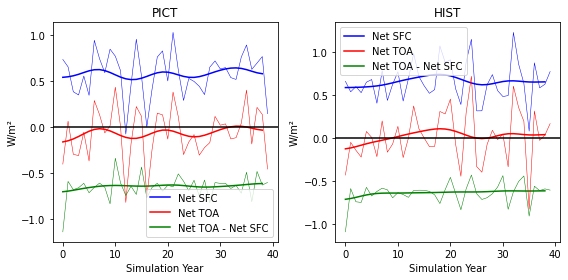

In [73]:
nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0

for key in input_names:

    axes[i].plot(smooth(surface[key],len(surface[key]),smooth_window),color='blue')
    axes[i].plot(smooth(toa[key],len(toa[key]),smooth_window),color='red')
    axes[i].plot(smooth(toa[key]-surface[key],len(toa[key]-surface[key]),smooth_window),color='green')

    axes[i].plot(surface[key],linewidth=0.5,color='blue')
    axes[i].plot(toa[key],linewidth=0.5,color='red')
    axes[i].plot(toa[key]-surface[key],linewidth=0.5,color='green')


    axes[i].axhline(y=0, color='black', linestyle='-')
    axes[i].set_ylabel('W/m²')
    axes[i].set_xlabel('Simulation Year')
    
    axes[i].set_title(key)
    axes[i].legend(['Net SFC', 'Net TOA', 'Net TOA - Net SFC'])
    plt.tight_layout() 

    i = i+1

    
if ofile is not None:
    ofile_long = f"{ofile}_imbalance_combined.png"
    plt.savefig(f"{ofile_long}", dpi=dpi)
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')